In [3]:
from collections import Counter
import copy as cp
import itertools
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
from photonic_circuit_solver import *
import random
import time
import qiskit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

class RingState:
    """
    Class for working with and storing information about an n node ring state.
    """

    def __init__(self, nodes:int):
        """
        Initializes class.

        Parameters:
        - nodes : Number of nodes the graph state contains.
        """

        self.nodes = nodes
        self.orderings = list()
        self.data = list()
    
    def __getitem__(self, index:int):
        """
        Returns ordering at index.

        Parameters:
        - index : Index of desired ordering from list of unique orderings.

        Returns:
        - self.orderings[index] : Ordering at index, returns none if an ordering does not exist at the index.
        """

        #checks if there are orderings, if not, generates them
        return self.orderings[index] if not self.orderings else None
    
    def get_all_orderings(self):
        """
        Generates all possible orderings for the ring state.
        
        Explaination:
            Generates all permutations of 1 through n-1, prepending each permuation with 0.
            If a permutation's first nonzero element is greater than the last element, it has already been 
            processed, and is equivalent to some element in the list of orderings.
            Each ordering is created using the form [0, 1], [1, 2], ... [n-1, 0].
        """

        time_start = time.time()

        self.orderings = list()

        permutations = [list(perm) for perm in itertools.permutations(range(self.nodes)[1:], self.nodes - 1)]
        for permutation in permutations:
            if permutation[0] == self.nodes-1: #reflective symmetry check 1
                break
            elif permutation[0] > permutation[-1]: #reflective symmetry check 2
                pass
            else:
                permutation.insert(0, 0)
                ordering = []
                for i in range(self.nodes):
                    edge = [permutation[i], permutation[i+1]] if i != self.nodes-1 else [permutation[i], permutation[0]] 
                    ordering.append(edge)
                self.orderings.append(ordering)
        
        print("Time taken (all orderings):", round((time.time()-time_start) * 1000, 3), "ms")

    def get_random_orderings(self, num_orderings:int):
        """
        Generates a number of possible orderings for the ring state.
        
        Parameters:
        - num_orderings : The number of random orderings to generate.
        """

        time_start = time.time()

        self.orderings = list()

        if num_orderings > math.factorial(self.nodes-1) / 2:
            num_orderings = math.factorial(self.nodes-1) / 2

        while len(self.orderings) < num_orderings:
            rd_permutation = list(range(self.nodes)[1:])
            random.shuffle(rd_permutation)
            if rd_permutation[0] > rd_permutation[-1] or rd_permutation[0] == self.nodes-1: #reflective symmetry check
                pass
            else:
                rd_permutation.insert(0, 0)
                ordering = []
                for i in range(self.nodes):
                    edge = [rd_permutation[i], rd_permutation[i+1]] if i != self.nodes-1 else [rd_permutation[i], rd_permutation[0]] 
                    ordering.append(edge)
                self.orderings.append(ordering)
        
        print("Time taken (all orderings):", round((time.time()-time_start) * 1000, 3), "ms")

    def add_ordering(self, ordering:list):

        self.orderings.append(ordering)


    def generate_data(self, ordering:list, index:int):
        """ 
        Generates relevant data for a given ordering.

        Parameters:
        - ordering : Node ordering to use.
        - index : Index of ordering.

        Returns:
        - ordering_data : Nested list containing relevant data.
        """

        qc = qiskit_circuit_solver(Stabilizer(edgelist=ordering))
        qcd = dict(qc.count_ops())
        num_cnot = qcd.get('cx') - self.nodes
        num_hadamard = qcd.get('h')
        depth = qc.depth()
        emitters = qc.num_qubits - self.nodes
        ordering_data = [["Index", index], ["# CNOT", num_cnot], ["# Hadamard", num_hadamard], ["# Emitter", emitters], ["Depth", depth]]
        
        return ordering_data

    def get_lowest(self, max=None):
        """ 
        Finds the ordering with the least number of CNOTs and Hadamards and the lowest depth.
        
        Explaination:
            Does a simple search across all orderings, creating a qiskit circuit for each and counting
            the number of CNOTs and Hadamards it consists of. All circuits contain a number of cnots
            equal to the number of nodes, so they are not accounted for.

        Parameters:
        - max : Maximum index to search up to.

        Returns:
        - l_index : Index of the ordering containing the least number of CNOTs, Hadamards, and depth.
        """

        time_start = time.time()

        #checks if there are orderings, if not, generates them
        self.get_all_orderings() if not self.orderings else None

        #checks if a maximum value is specified to search up to, default is all orderings
        max = len(self.orderings) if not max else max

        index = 0

        for ordering in self.orderings[0:max]:
            ord_data = self.generate_data(ordering, index)
            if index == 0:
                l_index = index
            else:
                cnot_check = ord_data[1][1] < self.data[l_index][1][1]
                hadamard_check = ord_data[1][1] == self.data[l_index][1][1] and ord_data[2][1] < self.data[l_index][2][1]
                depth_check = ord_data[1][1] == self.data[l_index][1][1] and ord_data[2][1] == self.data[l_index][2][1] and ord_data[4][1] < self.data[l_index][4][1]
                
                if cnot_check or hadamard_check or depth_check:
                    print("Previous lowest index :", l_index, "| New lowest index :", index)
                    l_index = index
                
            self.data.append(ord_data)
            index += 1

        self.lowest_qc = qiskit_circuit_solver(Stabilizer(edgelist=self.orderings[l_index]))
        self.lowest_index = l_index

        print("Time taken (lowest):", round((time.time()-time_start) * 1000, 3), "ms")

        return l_index
    
    def nx_plot(self, index:int):
        """
        Plots the ordering at index as a networkx graph.

        Parameters:
        - index : The index of the ordering to use.

        Returns:
        - G : Networkx graph of ring state at index.
        """

        G = nx.Graph()
        G.add_nodes_from(range(self.nodes))
        G.add_edges_from(self.orderings[index])
        return G

    def plot_data(self, x_index:int=1, y_index:int=2):
        """
        Plots data from two indicies as a pyplot.

        Parameters:
        - x_index : The index of the values to use for the x axis.
        - y_index : The index of the values to use for the y axis.
        """

        plot_data = cp.deepcopy(self.data)
        plot_data = np.array(plot_data)

        x_data = [int(i) for i in plot_data[:,x_index][:,1]]
        y_data = [int(i) for i in plot_data[:,y_index][:,1]]

        zip_data = tuple(zip(x_data, y_data))

        size = dict(Counter(zip_data))
        coords = list(size.keys())
        coords = np.array(coords)

        plt.scatter(coords[:,0], coords[:,1], s=list(size.values()))
        plt.xlabel(plot_data[0][x_index][0])
        plt.ylabel(plot_data[0][y_index][0])
        plt.show()

    def qiskit_noise_analysis(self, index:int, probability:float):
        """
        Simple error analysis for a given ordering's qiskit circuit.

        Parameters:
        - index : Index of ordering to analyze.
        - probability : The probability that a z error will occur.

        Returns:
        - result : Dictionary with relevant data on simulation.
        - fidelity : Fidelity of the noisy density matrix and blank state.
        """

        qc = qiskit_circuit_solver(Stabilizer(edgelist=self.orderings[index]))

        for emitter in range(self.nodes, qc.num_qubits):
            qc.measure(emitter, 0)
        for edge in self.orderings[index]:
            qc.cz(edge[0], edge[1])
        for photon in range(len(self.orderings[index])):
            qc.h(photon)
        qc.save_state()
        for photon in range(len(self.orderings[index])):
            qc.measure(photon, photon+1)

        z_error = pauli_error([("Z", probability), ("I", 1 - probability)])

        noise_model = NoiseModel()
        for emitter in range(self.nodes, qc.num_qubits):
            noise_model.add_quantum_error(z_error, "h", [emitter])
    
        simulation = AerSimulator(method='density_matrix', noise_model=noise_model)
        #qc = qiskit.transpile(qc, simulation)
        
        result = simulation.run(qc).result()

        dens_mat = result.data(0)["density_matrix"]

        blank_state = [0] * 2 ** qc.num_qubits
        blank_state[0] = 1
        blank_state = qiskit.quantum_info.Statevector(blank_state)

        fidelity = qiskit.quantum_info.state_fidelity(blank_state, dens_mat)

        return result, fidelity

In [5]:
rs = RingState(8)
lowest_data = rs.get_lowest()
print(rs.orderings[lowest_data])
print(rs.data[lowest_data])

Time taken (all orderings): 4.792 ms
Previous lowest index : 0 | New lowest index : 1
Previous lowest index : 1 | New lowest index : 11
Previous lowest index : 11 | New lowest index : 71
Time taken (lowest): 10140.825 ms
[[0, 1], [1, 2], [2, 5], [5, 7], [7, 6], [6, 4], [4, 3], [3, 0]]
[['Index', 71], ['# CNOT', 2], ['# Hadamard', 12], ['# Emitter', 2], ['Depth', 16]]


In [199]:
if False:

    rs = RingState(20)

    rs.get_random_orderings(1000)

    un_ord = list(range(0, 18))
    un_ord.append(19)
    un_ord.append(18)

    ordering = []
    for i in range(20):
        edge = [un_ord[i], un_ord[i+1]] if i != 19 else [un_ord[i], un_ord[0]] 
        ordering.append(edge)

    rs.add_ordering(ordering)

    print(len(rs.orderings))

    lowest_data = rs.get_lowest(max=None)

    print(rs.data[lowest_data])

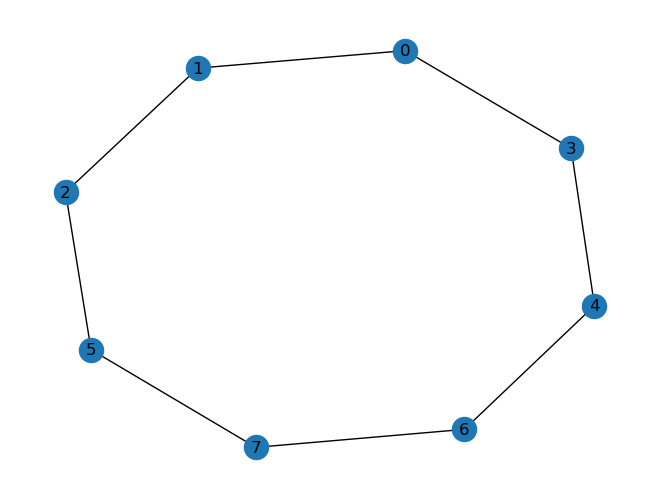

In [6]:
nx.draw(rs.nx_plot(lowest_data), with_labels=True)

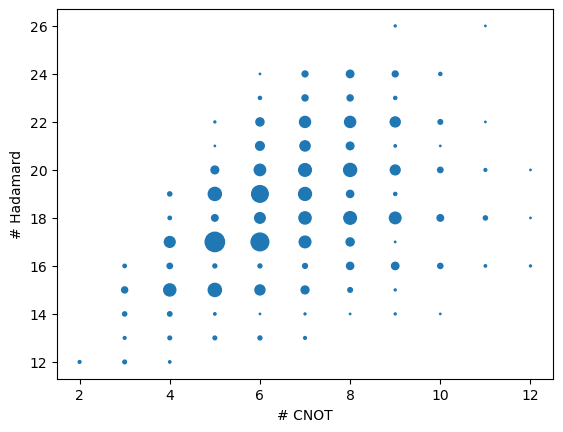

In [7]:
rs.plot_data(1, 2)

0.91352


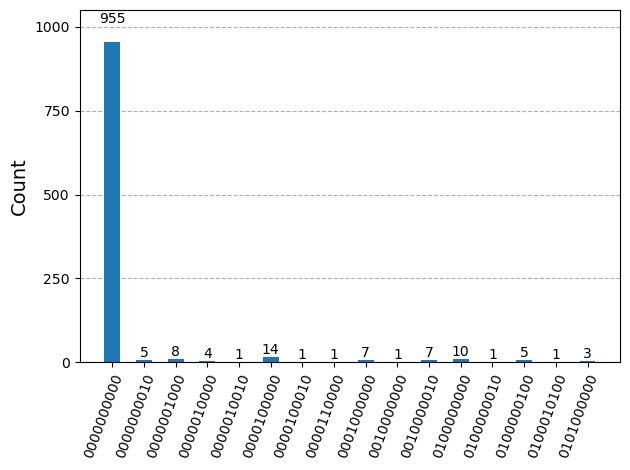

In [11]:
result, fidelity = rs.qiskit_noise_analysis(index=0, probability=0.01)

print(round(fidelity, 5))

plot_histogram(result.get_counts(0))

In [ ]:
for j in range(len(rs.data)):
    x_data = []
    y_data = []
    for i in range(0, 10):
        i = i/100
        result, fidelity = rs.qiskit_noise_analysis(j, i)
        x_data.append(i)
        y_data.append(round(fidelity, 5))
    
    print(y_data, rs.data[int(j)][0][1])
    
    plt.plot(x_data, y_data)
plt.legend(list(range(len(rs.data))))
plt.xlabel("Probability of Z Error")
plt.ylabel("Fidelity")
plt.show()

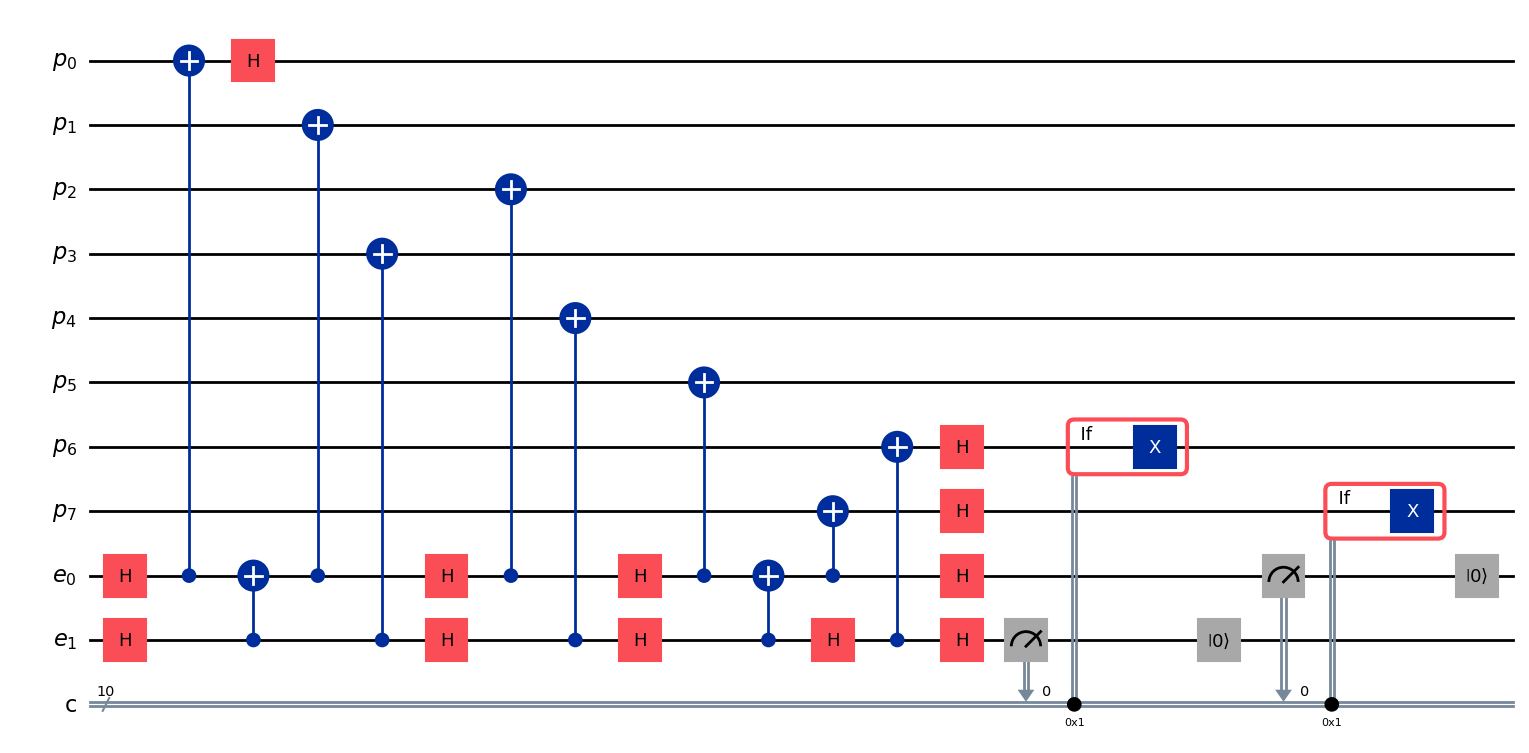

In [12]:
rs.lowest_qc.draw("mpl")